In [13]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm


def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):
    transform = Compose([ToTensor(),Normalize((0.1307,), (0.3081,)),Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(MNIST('./data/', train=True,download=True,transform=transform),batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(MNIST('./data/', train=False,download=True,transform=transform),batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader



In [14]:

def embed_label_into_data(x, y):
    x_ = x.clone()
    x_[:, :10] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_




In [15]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # optimizing the loss based on a threshold that negative data are below
            # and positive data are above that
            loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold,g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()


In [16]:
class Net(torch.nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers.append(Layer(dims[d], dims[d + 1]).cuda())

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = embed_label_into_data(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]

            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        print(f'goodness_per_label = {goodness_per_label.argmax(1)}')
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, ':')
            h_pos, h_neg = layer.train(h_pos, h_neg)


In [17]:
def original_pos_neg_image(x, x_pos, x_neg):
  x = x[0].cpu().reshape(28, 28)
  x_pos = x_pos[0].cpu().reshape(28, 28)
  x_neg = x_neg[0].cpu().reshape(28, 28)

  i=1
  for data, name in zip([x, x_pos, x_neg], ['original', 'pos', 'neg']):
    plt.subplot(1,3,i)
    i+=1
    plt.title(name)
    plt.imshow(data, cmap="gray")
  plt.show()

In [18]:

torch.manual_seed(0)
train_loader, test_loader = MNIST_loaders()

net = Net([784, 600, 500, 400])   #layers of the network
x, y = next(iter(train_loader))
x, y = x.cuda(), y.cuda()


torch.Size([50000, 784])


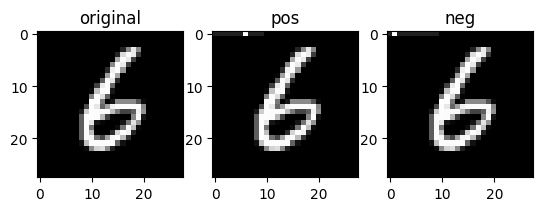

training layer 0 :


100%|██████████| 1000/1000 [01:09<00:00, 14.45it/s]


training layer 1 :


100%|██████████| 1000/1000 [00:47<00:00, 20.93it/s]


training layer 2 :


100%|██████████| 1000/1000 [00:36<00:00, 27.23it/s]


goodness_per_label = tensor([6, 3, 1,  ..., 7, 7, 3], device='cuda:0')
train accuracy =  0.914900004863739
goodness_per_label = tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')
test accuracy =  0.9192999601364136


In [19]:
x_pos = embed_label_into_data(x, y)

# adding the label with modulo that makes the label
#  something other than the original label
randint1 = torch.randint(1, 10, y.shape, device = 'cuda')
y_neg = torch.remainder(y + randint1, 10)
x_neg = embed_label_into_data(x, y_neg)

print(x.shape)

# plt.imshow(x_neg[1,:].reshape(28,28).cpu(), cmap="gray")
# plt.show()

# plt.imshow(x_neg[55,:].reshape(28,28).cpu(), cmap="gray")
# plt.show()

original_pos_neg_image(x, x_pos, x_neg)

net.train(x_pos, x_neg)

print('train accuracy = ', net.predict(x).eq(y).float().mean().item())

x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.cuda(), y_test.cuda()

print('test accuracy = ', net.predict(x_test).eq(y_test).float().mean().item())
